# Heat transport

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook) by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

____________
<a id='section1'></a>

## 1. Spatial patterns of insolation and surface temperature
____________

Let's take a look at seasonal and spatial pattern of insolation and compare this to the zonal average surface temperatures.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab
from climlab import constants as const

In [2]:
#  Calculate daily average insolation as function of latitude and time of year
lat = np.linspace( -90., 90., 500 )
days = np.linspace(0, const.days_per_year, 365 )
Q = climlab.solar.insolation.daily_insolation( lat, days )

In [3]:
##  daily surface temperature from  NCEP reanalysis
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_temp = xr.open_dataset( ncep_url + "surface_gauss/skt.sfc.day.1981-2010.ltm.nc", decode_times=False)
#url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/NCEP/NCEP/clima/'
#skt_path = 'surface_gauss/skt'
#ncep_temp = xr.open_dataset(url+skt_path)
ncep_temp_zon = ncep_temp.skt.mean(dim='lon')

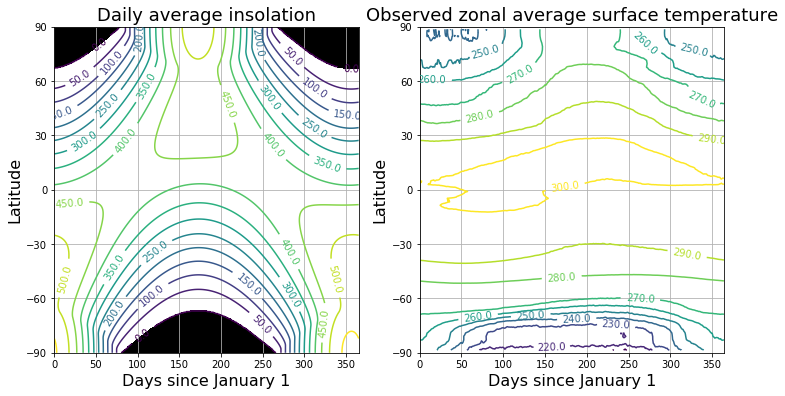

In [4]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
CS = ax1.contour( days, lat, Q , levels = np.arange(0., 600., 50.) )
ax1.clabel(CS, CS.levels, inline=True, fmt='%r', fontsize=10)
ax1.set_title('Daily average insolation', fontsize=18 )
ax1.contourf ( days, lat, Q, levels=[-100., 0.], colors='k' )

ax2 = fig.add_subplot(122)
CS = ax2.contour( (ncep_temp.time - ncep_temp.time[0])/const.hours_per_day, ncep_temp.lat, 
                 ncep_temp_zon.T, levels=np.arange(210., 310., 10. ) )
ax2.clabel(CS, CS.levels, inline=True, fmt='%r', fontsize=10)
ax2.set_title('Observed zonal average surface temperature', fontsize=18 )

for ax in [ax1,ax2]:
    ax.set_xlabel('Days since January 1', fontsize=16 )
    ax.set_ylabel('Latitude', fontsize=16 )
    ax.set_yticks([-90,-60,-30,0,30,60,90])
    ax.grid()

This figure reveals something fairly obvious, but still worth thinking about:

**Warm temperatures are correlated with high insolation**. It's warm where the sun shines.

More specifically, we can see a few interesting details here:

- The seasonal cycle is weakest in the tropics and strongest in the high latitudes.
- The warmest temperatures occur slighly NORTH of the equator
- The highest insolation occurs at the poles at summer solstice.

The local surface temperature does not correlate perfectly with local insolation for two reasons:

- the climate system has heat capacity, which buffers some of the seasonal variations
- the climate system moves energy around in space!

____________
<a id='section2'></a>

## 2. Calculating Radiative-Convective Equilibrium as a function of latitude
____________

As a first step to understanding the effects of **heat transport by fluid motions** in the atmosphere and ocean, we can calculate **what the surface temperature would be without any motion**.

Let's calculate a **radiative-convective equilibrium** state for every latitude band.

### Putting realistic insolation into an RCM

This code demonstrates how to create a model with both latitude and vertical dimensions.

In [5]:
# A two-dimensional domain
state = climlab.column_state(num_lev=30, num_lat=40, water_depth=10.)
#  Specified relative humidity distribution
h2o = climlab.radiation.ManabeWaterVapor(name='Fixed Relative Humidity', state=state)
#  Hard convective adjustment
conv = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment', state=state, adj_lapse_rate=6.5)
#  Daily insolation as a function of latitude and time of year
sun = climlab.radiation.DailyInsolation(name='Insolation', domains=state['Ts'].domain)
#  Couple the radiation to insolation and water vapor processes
rad = climlab.radiation.RRTMG(name='Radiation',
                             state=state, 
                             specific_humidity=h2o.q, 
                             albedo=0.125,
                             insolation=sun.insolation,
                             coszen=sun.coszen)
model = climlab.couple([rad,sun,h2o,conv], name='RCM')
print( model)

Opened data from /Users/br546577/opt/anaconda3/envs/climlab-courseware/lib/python3.8/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (40, 1) 
  Tatm: (40, 30) 
The subprocess tree: 
RCM: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   Fixed Relative Humidity: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   Convective Adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



In [6]:
model.compute_diagnostics()

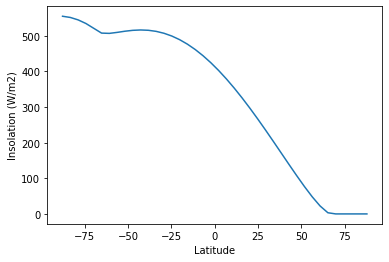

In [7]:
fig, ax = plt.subplots()
ax.plot(model.lat, model.insolation)
ax.set_xlabel('Latitude')
ax.set_ylabel('Insolation (W/m2)');

This new insolation process uses the same code we've already been working with to compute realistic distributions of insolation. Here we are using
```
climlab.radiation.DailyInsolation
```
but there is also

```
climlab.radiation.AnnualMeanInsolation
```
for models in which you prefer to suppress the seasonal cycle and prescribe a time-invariant insolation.

The following code will just integrate the model forward in four steps in order to get snapshots of insolation at the solstices and equinoxes.

In [8]:
#  model is initialized on Jan. 1

#  integrate forward just under 1/4 year... should get about to the NH spring equinox
model.integrate_days(31+28+22)
Q_spring = model.insolation.copy()
#  Then forward to NH summer solstice
model.integrate_days(31+30+31)
Q_summer = model.insolation.copy()
#  and on to autumnal equinox
model.integrate_days(30+31+33)
Q_fall = model.insolation.copy()
#  and finally to NH winter solstice
model.integrate_days(30+31+30)
Q_winter = model.insolation.copy()

Integrating for 81 steps, 81.0 days, or 0.22177064972229385 years.
Total elapsed time is 0.22177064972229385 years.
Integrating for 91 steps, 91.99999999999999 days, or 0.2518876515364325 years.
Total elapsed time is 0.4709203920028956 years.
Integrating for 94 steps, 94.00000000000001 days, or 0.2573634700480941 years.
Total elapsed time is 0.7282838620509897 years.
Integrating for 91 steps, 91.0 days, or 0.24914974228060174 years.
Total elapsed time is 0.9774336043315914 years.


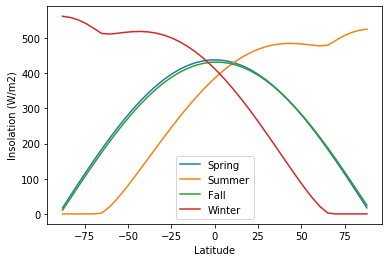

In [9]:
fig, ax = plt.subplots()
ax.plot(model.lat, Q_spring, label='Spring')
ax.plot(model.lat, Q_summer, label='Summer')
ax.plot(model.lat, Q_fall, label='Fall')
ax.plot(model.lat, Q_winter, label='Winter')
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('Insolation (W/m2)');

This just serves to demonstrate that the `DailyInsolation` process is doing something sensible.

Note that we could also pass different orbital parameters to this subprocess. They default to present-day values, which is what we are using here.

### Find the steady seasonal cycle of temperature in radiative-convective equilibrium

In [10]:
model.integrate_years(4.)

Integrating for 1460 steps, 1460.9688 days, or 4.0 years.
Total elapsed time is 4.974781117844542 years.


In [11]:
model.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 5.97411799622278 years.


All climlab `Process` objects have an attribute called `timeave`. 

This is a dictionary of time-averaged diagnostics, which are automatically calculated during the most recent call to `integrate_years()` or `integrate_days()`.

In [12]:
model.timeave.keys()

dict_keys(['Ts', 'Tatm', 'OLR', 'OLRclr', 'OLRcld', 'TdotLW', 'TdotLW_clr', 'LW_sfc', 'LW_sfc_clr', 'LW_flux_up', 'LW_flux_down', 'LW_flux_net', 'LW_flux_up_clr', 'LW_flux_down_clr', 'LW_flux_net_clr', 'ASR', 'ASRclr', 'ASRcld', 'TdotSW', 'TdotSW_clr', 'SW_sfc', 'SW_sfc_clr', 'SW_flux_up', 'SW_flux_down', 'SW_flux_net', 'SW_flux_up_clr', 'SW_flux_down_clr', 'SW_flux_net_clr', 'insolation', 'coszen', 'q'])

Here we use the `timeave['insolation']` to plot the annual mean insolation. 

(We know it is the *annual* average because the last call to `model.integrate_years` was for exactly 1 year)

Text(0, 0.5, 'Insolation (W/m2)')

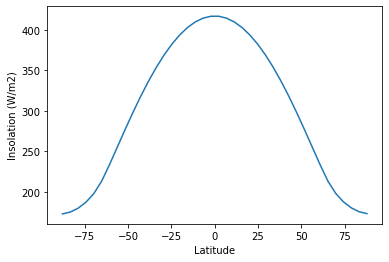

In [13]:
fig, ax = plt.subplots()
ax.plot(model.lat, model.timeave['insolation'])
ax.set_xlabel('Latitude')
ax.set_ylabel('Insolation (W/m2)')

###  Compare annual average temperature in RCE to the zonal-, annual mean observations.

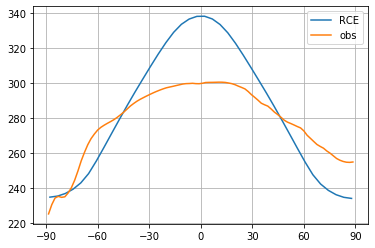

In [14]:
# Plot annual mean surface temperature in the model,
#   compare to observed annual mean surface temperatures
fig, ax = plt.subplots()
ax.plot(model.lat, model.timeave['Ts'], label='RCE')
ax.plot(ncep_temp_zon.lat, ncep_temp_zon.mean(dim='time'), label='obs')
ax.set_xticks(range(-90,100,30))
ax.grid(); ax.legend();

Our modeled RCE state is **far too warm in the tropics**, and **too cold in the mid- to high latitudes.**

###  Vertical structure of temperature: comparing RCE to observations

In [15]:
#  Observed air temperature from NCEP reanalysis
## The NOAA ESRL server is shutdown! January 2019
ncep_air = xr.open_dataset( ncep_url + "pressure/air.mon.1981-2010.ltm.nc", decode_times=False)
#air = xr.open_dataset(url+'pressure/air')
#ncep_air = air.rename({'lev':'level'})
level_ncep_air = ncep_air.level
lat_ncep_air = ncep_air.lat
Tzon = ncep_air.air.mean(dim=('time','lon'))

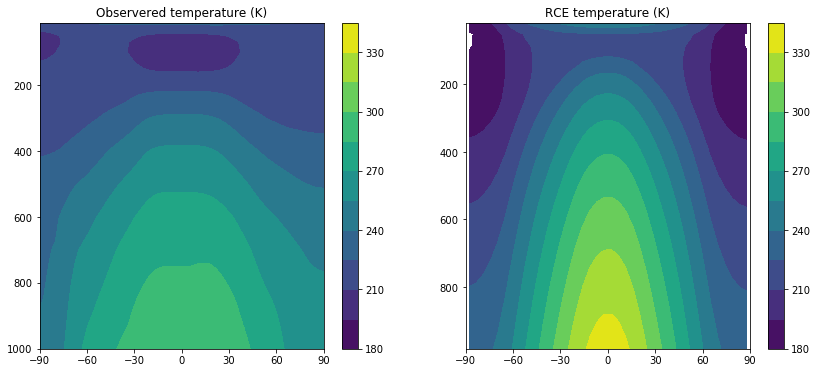

In [16]:
#  Compare temperature profiles in RCE and observations
contours = np.arange(180., 350., 15.)

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1,2,1)
cax1 = ax1.contourf(lat_ncep_air, level_ncep_air, Tzon+const.tempCtoK, levels=contours)
fig.colorbar(cax1)
ax1.set_title('Observered temperature (K)')

ax2 = fig.add_subplot(1,2,2)
field = model.timeave['Tatm'].transpose()
cax2 = ax2.contourf(model.lat, model.lev, field, levels=contours)
fig.colorbar(cax2)
ax2.set_title('RCE temperature (K)')

for ax in [ax1, ax2]:
    ax.invert_yaxis()
    ax.set_xlim(-90,90)
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])

Again, this plot reveals temperatures that are too warm in the tropics, too cold at the poles throughout the troposphere.

Note however that the **vertical temperature gradients** are largely dictated by the convective adjustment in our model. We have parameterized this gradient, and so we can change it by changing our parameter for the adjustment.

We have (as yet) no parameterization for the **horizontal** redistribution of energy in the climate system.

###  TOA energy budget in RCE equilibrium

Because there is no horizontal energy transport in this model, the TOA radiation budget should be closed (net flux is zero) at all latitudes.

Let's check this by plotting time-averaged shortwave and longwave radiation:

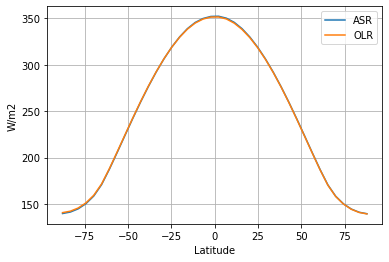

In [17]:
fig, ax = plt.subplots()
ax.plot(model.lat, model.timeave['ASR'], label='ASR')
ax.plot(model.lat, model.timeave['OLR'], label='OLR')
ax.set_xlabel('Latitude')
ax.set_ylabel('W/m2')
ax.legend(); ax.grid()

Indeed, the budget is (very nearly) closed everywhere. Each latitude is in energy balance, independent of every other column.

____________
<a id='section3'></a>

## 3. Observed and modeled TOA radiation budget
____________


We are going to look at the (time average) TOA budget as a function of latitude to see how it differs from the RCE state we just plotted.

Ideally we would look at actual satellite observations of SW and LW fluxes. Instead, here we will use the NCEP Reanalysis for convenience. 

But bear in mind that the radiative fluxes in the reanalysis are a model-generated product, they are not really observations.

### TOA budget from NCEP Reanalysis

In [18]:
# Get TOA radiative flux data from NCEP reanalysis
# downwelling SW
dswrf = xr.open_dataset(ncep_url + '/other_gauss/dswrf.ntat.mon.1981-2010.ltm.nc', decode_times=False)
#dswrf = xr.open_dataset(url + 'other_gauss/dswrf')
#  upwelling SW
uswrf = xr.open_dataset(ncep_url + '/other_gauss/uswrf.ntat.mon.1981-2010.ltm.nc', decode_times=False)
#uswrf = xr.open_dataset(url + 'other_gauss/uswrf')
#  upwelling LW
ulwrf = xr.open_dataset(ncep_url + '/other_gauss/ulwrf.ntat.mon.1981-2010.ltm.nc', decode_times=False)
#ulwrf = xr.open_dataset(url + 'other_gauss/ulwrf')

In [19]:
ASR = dswrf.dswrf - uswrf.uswrf
OLR = ulwrf.ulwrf

In [20]:
ASRzon = ASR.mean(dim=('time','lon'))
OLRzon = OLR.mean(dim=('time','lon'))

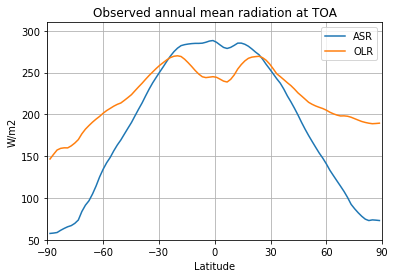

In [21]:
ticks = [-90, -60, -30, 0, 30, 60, 90]
fig, ax = plt.subplots()
ax.plot(ASRzon.lat, ASRzon, label='ASR')
ax.plot(OLRzon.lat, OLRzon, label='OLR')
ax.set_ylabel('W/m2')
ax.set_xlabel('Latitude')
ax.set_xlim(-90,90); ax.set_ylim(50,310)
ax.set_xticks(ticks);
ax.set_title('Observed annual mean radiation at TOA')
ax.legend(); ax.grid();

We find that ASR does NOT balance OLR in most locations. 

Across the tropics the absorbed solar radiation exceeds the longwave emission to space.  The tropics have a **net gain of energy by radiation**.

The opposite is true in mid- to high latitudes: **the Earth is losing energy by net radiation to space** at these latitudes.

### TOA budget from the control CESM simulation

Load data from the fully coupled CESM control simulation that we've used before.

In [22]:
casenames = {'cpl_control': 'cpl_1850_f19',
             'cpl_CO2ramp': 'cpl_CO2ramp_f19',
             'som_control': 'som_1850_f19',
             'som_2xCO2':   'som_1850_2xCO2',
            }
# The path to the THREDDS server, should work from anywhere
basepath = 'http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/'
# For better performance if you can access the roselab_rit filesystem (e.g. from JupyterHub)
#basepath = '/roselab_rit/cesm_archive/'
casepaths = {}
for name in casenames:
    casepaths[name] = basepath + casenames[name] + '/concatenated/'

# make a dictionary of all the CAM atmosphere output
atm = {}
for name in casenames:
    path = casepaths[name] + casenames[name] + '.cam.h0.nc'
    print('Attempting to open the dataset ', path)
    atm[name] = xr.open_dataset(path)

Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_CO2ramp_f19/concatenated/cpl_CO2ramp_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/som_1850_f19/concatenated/som_1850_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/som_1850_2xCO2/concatenated/som_1850_2xCO2.cam.h0.nc


In [23]:
lat_cesm = atm['cpl_control'].lat
ASR_cesm = atm['cpl_control'].FSNT
OLR_cesm = atm['cpl_control'].FLNT

In [24]:
# extract the last 10 years from the slab ocean control simulation
# and the last 20 years from the coupled control
nyears_slab = 10
nyears_cpl = 20
clim_slice_slab = slice(-(nyears_slab*12),None)
clim_slice_cpl = slice(-(nyears_cpl*12),None)

#  For now we're just working with the coupled control simulation
#  Take the time and zonal average
ASR_cesm_zon = ASR_cesm.isel(time=clim_slice_slab).mean(dim=('lon','time'))
OLR_cesm_zon = OLR_cesm.isel(time=clim_slice_slab).mean(dim=('lon','time'))

Now we can make the same plot of ASR and OLR that we made for the observations above.

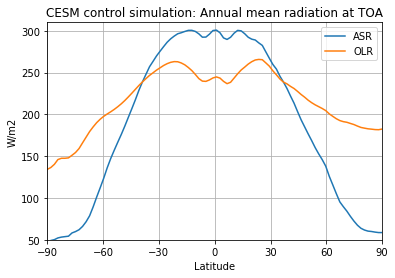

In [25]:
fig, ax = plt.subplots()
ax.plot(lat_cesm, ASR_cesm_zon, label='ASR')
ax.plot(lat_cesm, OLR_cesm_zon, label='OLR')
ax.set_ylabel('W/m2')
ax.set_xlabel('Latitude')
ax.set_xlim(-90,90); ax.set_ylim(50,310)
ax.set_xticks(ticks);
ax.set_title('CESM control simulation: Annual mean radiation at TOA')
ax.legend(); ax.grid();

Essentially the same story as the reanalysis data: there is a **surplus of energy across the tropics** and a net **energy deficit in mid- to high latitudes**.

There are two locations where ASR = OLR, near about 35º in both hemispheres. 

____________

## 4. The energy budget for a zonal band
____________

### The basic idea

Through most of the previous notes we have been thinking about **global averages**.

We've been working with an energy budget that looks something like this:

<img src='../images/column_sketch.pdf' width=200>

When we start thinking about regional climates, we need to modify our budget to account for the **additional heating or cooling** due to **transport** in and out of the column:

<img src='../images/column_sketch2.pdf' width=200>

Conceptually, the additional energy source is the difference between what's coming in and what's going out:

$$ h = \mathcal{H}_{in}  - \mathcal{H}_{out} $$

where $h$ is a **dynamic heating rate** in W m$^{-2}$.

### A more careful budget

Let’s now consider a thin band of the climate system, of width $\delta \phi$ , and write down a careful energy budget for it.

<img src='../images/ZonalEnergyBudget_sketch.png' width=400>

Let $\mathcal{H}(\phi)$ be the total rate of northward energy transport across the latitude line $\phi$, measured in Watts (usually PW).

So the transport into the band is $\mathcal{H}(\phi)$, and the transport out is just $\mathcal{H}(\phi + \delta \phi)$

The dynamic heating rate looks like

$$ h = \frac{\text{transport in} - \text{transport out}}{\text{area of band}} $$

The surface area of the latitude band is

$$ A = \text{Circumference} ~\times ~ \text{north-south width} $$

$$ A = 2 \pi a \cos \phi  ~ \times ~  a \delta \phi  $$

$$ A = 2 \pi a^2  \cos⁡\phi ~ \delta\phi $$

So we can write the heating rate as

\begin{align*}
h &= \frac{\mathcal{H}(\phi) - \mathcal{H}(\phi+\delta\phi)}{2 \pi a^2  \cos⁡\phi ~ \delta\phi} \\
 &= -\frac{1}{2 \pi a^2  \cos⁡\phi} \left( \frac{\mathcal{H}(\phi+\delta\phi) - \mathcal{H}(\phi)}{\delta\phi} \right)
\end{align*}

Writing it this way, we can see that if the width of the band $\delta \phi$ becomes very small, then the quantity in parentheses is simply the **derivative** $d\mathcal{H}/d\phi$.

The **dynamical heating rate** in W m$^{-2}$ is thus

$$ h = - \frac{1}{2 \pi a^2  \cos⁡\phi } \frac{\partial \mathcal{H}}{\partial \phi} $$

which is the **convergence of energy transport** into this latitude band: the difference between what's coming in and what's going out.

____________

## 5. Calculating heat transport from the steady-state energy budget
____________


If we can **assume that the budget is balanced**, i.e. assume that the system is at equilibrium and there is negligible heat storage, then we can use the energy budget to infer $\mathcal{H}$ from a measured (or modeled) TOA radiation imbalance:

The balanced budget is

$$ ASR + h = OLR $$

(i.e. the **sources** balance the **sinks**)

which we can substitute in for $h$ and rearrange to write as

$$ \frac{\partial \mathcal{H}}{\partial \phi}  = 2 \pi ~a^2  \cos⁡\phi ~ \left( \text{ASR} - \text{OLR} \right)  = 2 \pi ~a^2  \cos⁡\phi ~ R_{TOA} $$

where for convenience we write $R_{TOA} = ASR - OLR$, the net downward flux at the top of atmosphere.

Now integrate from the South Pole ($\phi = -\pi/2$):

$$ \int_{-\pi/2}^{\phi} \frac{\partial \mathcal{H}}{\partial \phi^\prime}  d\phi^\prime = 2 \pi ~a^2 \int_{-\pi/2}^{\phi} \cos⁡\phi^\prime ~ R_{TOA} d\phi^\prime  $$

$$ \mathcal{H}(\phi) - \mathcal{H}(-\pi/2) = 2 \pi ~a^2 \int_{-\pi/2}^{\phi} \cos⁡\phi^\prime ~ R_{TOA} d\phi^\prime  $$

Our boundary condition is that the transport must go to zero at the pole. We therefore have a formula for calculating the heat transport at any latitude, by integrating the imbalance from the South Pole:

$$ \mathcal{H}(\phi) = 2 \pi ~a^2 \int_{-\pi/2}^{\phi} \cos⁡\phi^\prime ~ R_{TOA} d\phi^\prime  $$

What about the boundary condition at the other pole? We must have $\mathcal{H}(\pi/2) = 0$ as well, because a non-zero transport at the pole is not physically meaningful.

Notice that if we apply the above formula and integrate all the way to the other pole, we then have

$$ \mathcal{H}(\pi/2) = 2 \pi ~a^2 \int_{-\pi/2}^{\pi/2} \cos⁡\phi^\prime ~ R_{TOA} d\phi^\prime  $$

This is an integral of the radiation imbalance weighted by cosine of latitude. In other words, this is **proportional to the area-weighted global average energy imbalance**.

We started by assuming that this imbalance is zero.

If the **global budget is balanced**, then the physical boundary condition of no-flux at the poles is satisfied.

____________

## 6. Poleward heat transport in the CESM
____________


Here we will code up a function that performs the above integration.

In [26]:
def inferred_heat_transport(energy_in, lat=None, latax=None):
    '''Compute heat transport as integral of local energy imbalance.
    Required input:
        energy_in: energy imbalance in W/m2, positive in to domain
    As either numpy array or xarray.DataArray
    If using plain numpy, need to supply these arguments:
        lat: latitude in degrees
        latax: axis number corresponding to latitude in the data
            (axis over which to integrate)
    returns the heat transport in PW.
    Will attempt to return data in xarray.DataArray if possible.
    '''
    from scipy import integrate
    from climlab import constants as const
    if lat is None:
        try: lat = energy_in.lat
        except:
            raise InputError('Need to supply latitude array if input data is not self-describing.')
    lat_rad = np.deg2rad(lat)
    coslat = np.cos(lat_rad)
    field = coslat*energy_in
    if latax is None:
        try: latax = field.get_axis_num('lat')
        except:
            raise ValueError('Need to supply axis number for integral over latitude.')
    #  result as plain numpy array
    integral = integrate.cumtrapz(field, x=lat_rad, initial=0., axis=latax)
    result = (1E-15 * 2 * np.math.pi * const.a**2 * integral)
    if isinstance(field, xr.DataArray):
        result_xarray = field.copy()
        result_xarray.values = result
        return result_xarray
    else:
        return result

Let's now use this to calculate the total northward heat transport from our control simulation with the CESM:

Text(0.5, 1.0, 'Total northward heat transport inferred from CESM control simulation')

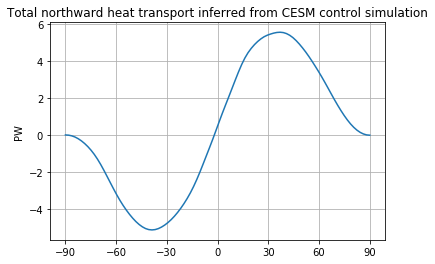

In [27]:
fig, ax = plt.subplots()
ax.plot(lat_cesm, inferred_heat_transport(ASR_cesm_zon - OLR_cesm_zon))
ax.set_ylabel('PW')
ax.set_xticks(ticks)
ax.grid()
ax.set_title('Total northward heat transport inferred from CESM control simulation')

The total heat transport is very nearly symmetric about the equator, with poleward transport of about 5 to 6 PW in both hemispheres.

The transport peaks in magnitude near 35º latitude, the same latitude where we found that ASR = OLR. This is no coincidence!

Equatorward of 35º (across the tropics) there is **net heating by radiation** and **net cooling by dynamics**. The opposite is true poleward of 35º.

### An example of a recently published observational estimate of meridional heat transport

<img src='../images/Fasullo_Trenberth_2008b_Fig7.jpg'>

> The ERBE period zonal mean annual cycle of the meridional energy transport in PW by (a) the atmosphere and ocean as inferred from ERBE $R_T$, NRA $\delta$A_E/$\delta$t, and GODAS $\delta$O_E/$\delta$t; (b) the atmosphere based on NRA; and (c) by the ocean as implied by ERBE + NRA $F_S$ and GODAS $\delta$O_E/$\delta$t. Stippling and hatching in (a)–(c) represent regions and times of year in which the standard deviation of the monthly mean values among estimates, some of which include the CERES period (see text), exceeds 0.5 and 1.0 PW, respectively. (d) The median annual mean transport by latitude for the total (gray), atmosphere (red), and ocean (blue) accompanied with the associated $\pm2\sigma$ range (shaded).

This is a reproduction of Figure 7 from Fasullo and Trenberth (2008), "The Annual Cycle of the Energy Budget. Part II: Meridional Structures and Poleward Transports", J. Climate 21, doi:10.1175/2007JCLI1936.1

This figure shows the breakdown of the heat transport by **season** as well as the **partition between the atmosphere and ocean**.

Focussing just on the total, annual transport in panel (d) (black curve), we see that is quite consistent with what we computed from the CESM simulation.

____________

## Credits

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook), an open-source textbook developed and maintained by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It is licensed for free and open consumption under the
[Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license.

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________